読み込み


In [ ]:
!pip install japanize_matplotlib
import japanize_matplotlib  # matplotlibの日本語対応

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 35.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=de87e98001d730683fa5e5fe188a123c16be69696373e725fd380bf5b0c4702b
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import os
import json
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, dendrogram

In [ ]:
sts_all =  pd.read_json("STS_All.json")
all_df = sts_all[['id', 'publication_year', 'referenced_works',
        'journal_name']]

In [ ]:
#年代ごとにdfを分割
# 5年区切りのデータフレームを作成
df_1990s = all_df[(all_df["publication_year"] > 1990) & (all_df["publication_year"] < 1996)]
df_1995s = all_df[(all_df["publication_year"] > 1995) & (all_df["publication_year"] < 2001)]
df_2000s = all_df[(all_df["publication_year"] > 2000) & (all_df["publication_year"] < 2006 )]
df_2005s = all_df[(all_df["publication_year"] > 2005) & (all_df["publication_year"] < 2011)]
df_2010s = all_df[(all_df["publication_year"] > 2010) & (all_df["publication_year"] < 2016)]
df_2015s = all_df[(all_df["publication_year"] > 2015) & (all_df["publication_year"] < 2021) ]
df_2020s = all_df[all_df["publication_year"] > 2020]

df_lst = [df_1990s, df_1995s, df_2000s, df_2005s, df_2010s, df_2015s, df_2020s]
for df in df_lst:
  df.reset_index(drop=True, inplace=True)

In [ ]:
j_1991, j_1996, j_2001, j_2006, j_2011, j_2016, j_2021 = "1991.json", "1996.json", "2001.json", "2006.json", "2011.json", "2016.json", "2021.json"

In [ ]:
# 略称辞書の定義（キーを小文字に変換）
abbreviation_dict = {
    'social studies of science': 'SSS',
    'science, technology & human values': 'STHV',
    'science, technology, & human values': 'STHV',
    'science technology & human values': 'STHV',
    'public understanding of science': 'PUS',
    'science as culture': 'SasC',
    'research policy': 'RePoli',
    'science technology and society': 'STS',
    'research evaluation': 'ReEval',
    'east asian science technology and society an international journal': 'EASTS',
    'science communication': 'SciCom',
    'journal of responsible innovation': 'JRI',
    'journal of responsible innovation': 'JRI',
    'technology in society': 'TIS',
    'science and public policy': 'SPP',
    'journal of science communication': 'JCOM',
    'scientometrics': 'SciMet',
    'technovation': 'TechNov'
}

In [ ]:
year_list = list(range(1991, 2026, 5))

In [ ]:
year_list

[1991, 1996, 2001, 2006, 2011, 2016, 2021]

# OpenAlexのデータを用いた場合

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from collections import defaultdict

class CitationNetworkClustering:
    def __init__(self, df, linkage_method='ward'):
        """
        クラスの初期化
        :param df: 所与のデータフレーム
        :param linkage_method: クラスタリングの基準（例: 'ward', 'single', 'complete', 'average'）
        """
        self.df = df
        self.journals = sorted(df['journal_name'].unique())  # ジャーナルのリストを抽出
        self.journal_index = {journal: i for i, journal in enumerate(self.journals)}  # ジャーナル名→インデックス
        self.citation_matrix = None  # 引用行列
        self.id_journal_dict = self.create_id_journal_dict()  # idとジャーナル名の辞書を作成
        self.linkage_method = linkage_method  # クラスタリング基準

        # デンドログラム画像リスト
        self.dendrogram_figures = []

    def create_id_journal_dict(self):
        """
        論文IDとジャーナル名の辞書を作成
        """
        id_journal_dict = pd.Series(self.df['journal_name'].values, index=self.df['id']).to_dict()
        return id_journal_dict

    def build_citation_matrix(self, df, normalize=False):
        """
        ジャーナル間の引用行列を構築
        :param df: 対象のデータフレーム
        :param normalize: 正規化の有無 (デフォルト: False)
        """
        num_journals = len(self.journals)
        citation_matrix = np.zeros((num_journals, num_journals), dtype=float if normalize else int)

        journal_paper_count = self.df['journal_name'].value_counts().to_dict()

        for _, row in df.iterrows():
            source_journal = row['journal_name']
            if not row['referenced_works']:
                continue

            for referenced_work in row['referenced_works']:
                target_journal = self.id_journal_dict.get(referenced_work)
                if not target_journal:
                    continue

                citation_matrix[self.journal_index[source_journal], self.journal_index[target_journal]] += 1

        if normalize:
            for i in range(num_journals):
                for j in range(num_journals):
                    if citation_matrix[i, j] > 0:
                        citation_matrix[i, j] /= (journal_paper_count.get(self.journals[i], 0) + \
                                                  journal_paper_count.get(self.journals[j], 0))

        non_zero_indices = ~np.all(citation_matrix == 0, axis=1)
        citation_matrix = citation_matrix[non_zero_indices][:, non_zero_indices]

        self.filtered_journals = [journal for i, journal in enumerate(self.journals) if non_zero_indices[i]]

        self.citation_matrix = citation_matrix
        return citation_matrix

    def plot_dendrogram(self, period, threshold=None, figure_size=(8, 6)):
        """
        階層的クラスタリングとデンドログラムの描画
        :param period: 対象期間の文字列（例: "1990-1995"）
        :param threshold: クラスタリングの閾値 (デフォルト: None)
        :param figure_size: 描画サイズ (デフォルト: (8, 6))
        """
        if self.citation_matrix is None:
            raise ValueError("Citation matrix has not been built. Run build_citation_matrix() first.")

        distance_matrix = 1 / (self.citation_matrix + 1)

        linkage_matrix = linkage(distance_matrix, method=self.linkage_method)

        fig, ax = plt.subplots(figsize=figure_size)
        dendro = dendrogram(
            linkage_matrix,
            labels=self.filtered_journals,
            leaf_rotation=90,
            leaf_font_size=10,
            color_threshold=threshold,
            ax=ax
        )
        ax.set_title(f"デンドログラム ({period})")
        ax.set_xlabel("ジャーナル")
        ax.set_ylabel("距離")

        for i, d in zip(dendro['icoord'], dendro['dcoord']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            ax.text(x, y, f'{y:.2f}', va='bottom', ha='center', fontsize=9, color='blue')

        self.dendrogram_figures.append(fig)


    def process_time_periods(self, normalize=False, linkage_method='ward', threshold=None):
        """
        5年ごとにデータを分割して処理
        :param normalize: 正規化の有無 (デフォルト: False)
        :param linkage_method: クラスタリング基準（例: 'ward', 'single', 'complete', 'average'）
        :param threshold: クラスタリングの閾値 (デフォルト: None)
        """
        start_year = 1991
        end_year = self.df['publication_year'].max()

        time_periods = {}
        current_start = start_year

        while current_start <= end_year:
            next_start = current_start + 5
            period_label = f"{current_start}-{min(next_start - 1, end_year)}"
            if next_start > end_year:
                time_periods[period_label] = self.df[self.df["publication_year"] >= current_start]
            else:
                time_periods[period_label] = self.df[(self.df["publication_year"] >= current_start) & (self.df["publication_year"] < next_start)]
            current_start = next_start

        for period, period_df in time_periods.items():
            print(f"{period}のデータを処理中...")
            self.linkage_method = linkage_method
            self.build_citation_matrix(period_df, normalize=normalize)
            print(f"{period}のデンドログラムを描画中...")
            self.plot_dendrogram(period, threshold=threshold)

    def combine_last_plots(self):
        """
        最後の4つのプロットを2x2に配置した一枚の図を作成。
        プロットは画像として取得して再描画。
        """
        if len(self.dendrogram_figures) < 4:
            print("プロットが4枚未満です。")
            return

        # 最後の4つの図を取得
        last_4_figures = self.dendrogram_figures[-4:]

        # 2x2の配置で新しい図を作成
        fig, axes = plt.subplots(2, 2, figsize=(20, 14))

        for i, ax in enumerate(axes.flatten()):
            if i < len(last_4_figures):
                last_fig = last_4_figures[i]

                # 図を画像データとして取得
                last_fig.tight_layout()
                last_fig.canvas.draw()
                img_array = np.frombuffer(last_fig.canvas.tostring_rgb(), dtype=np.uint8)
                img_array = img_array.reshape(last_fig.canvas.get_width_height()[::-1] + (3,))

                # 画像データを新しいプロットに配置
                ax.imshow(img_array)
                ax.axis('off')  # 軸を非表示に
            else:
                ax.axis('off')  # 余分なプロット枠を非表示

        # 全体のタイトルとレイアウト調整
        plt.suptitle('階層型クラスタリング', fontsize=25)
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()



1991-1995のデータを処理中...
1991-1995のデンドログラムを描画中...
1996-2000のデータを処理中...
1996-2000のデンドログラムを描画中...
2001-2005のデータを処理中...
2001-2005のデンドログラムを描画中...
2006-2010のデータを処理中...
2006-2010のデンドログラムを描画中...
2011-2015のデータを処理中...
2011-2015のデンドログラムを描画中...
2016-2020のデータを処理中...
2016-2020のデンドログラムを描画中...
2021-2024のデータを処理中...
2021-2024のデンドログラムを描画中...


<ipython-input-11-b7be67a2ae9f>:155: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img_array = np.frombuffer(last_fig.canvas.tostring_rgb(), dtype=np.uint8)


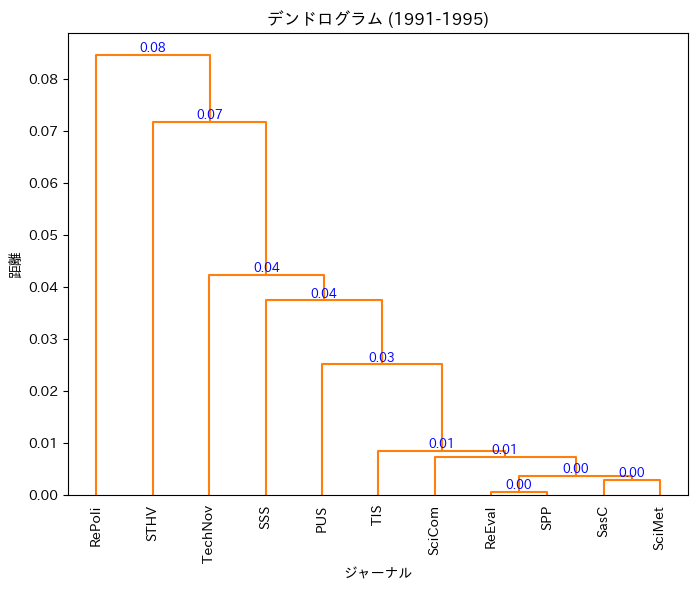

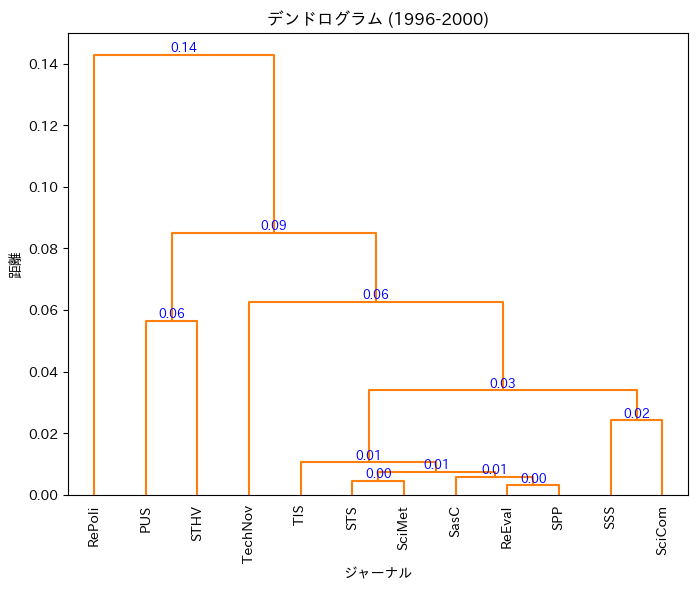

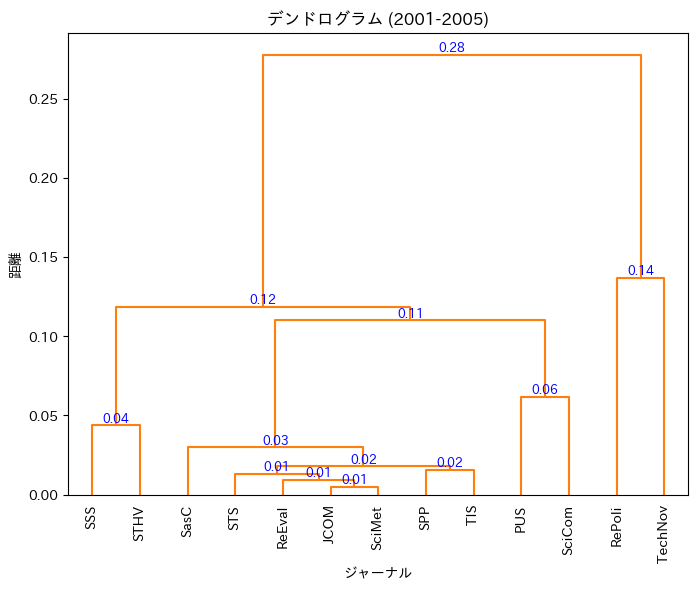

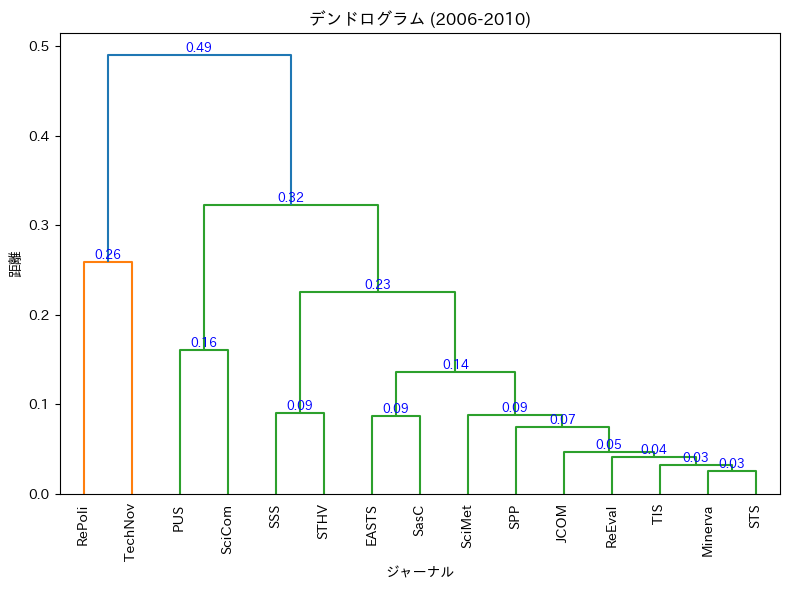

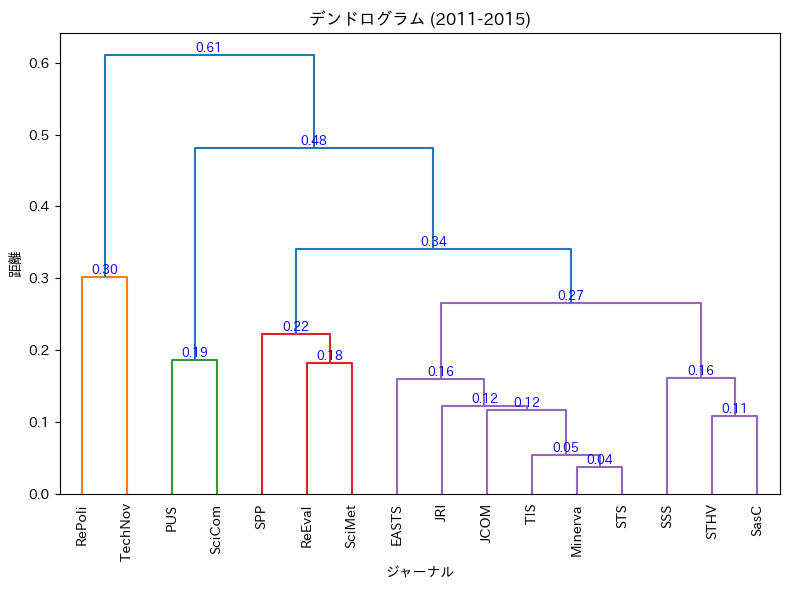

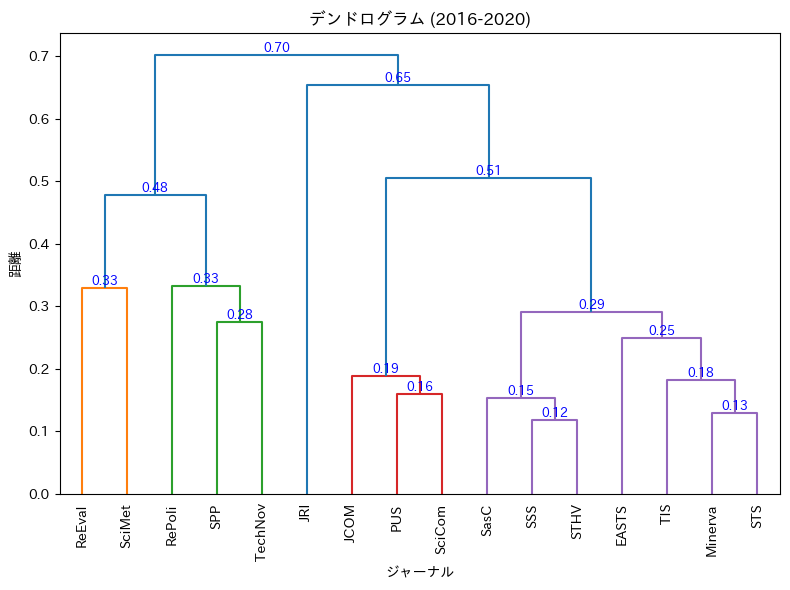

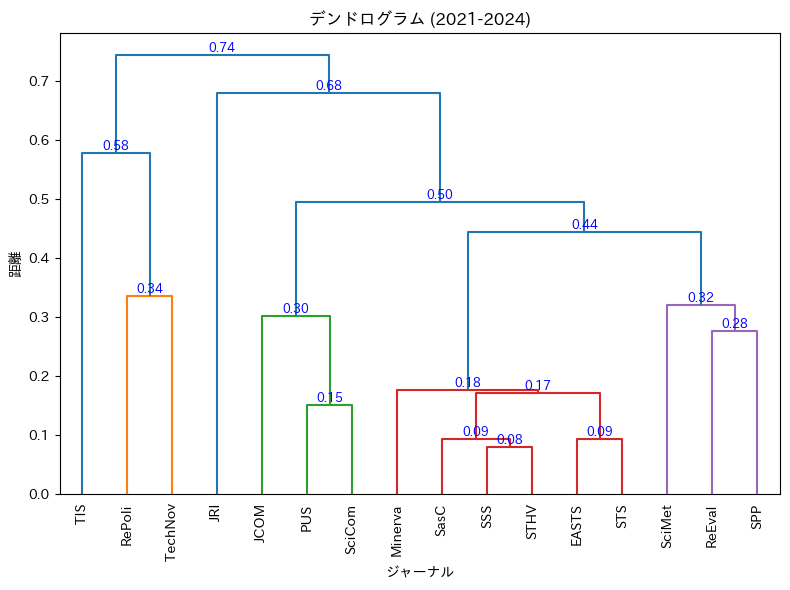

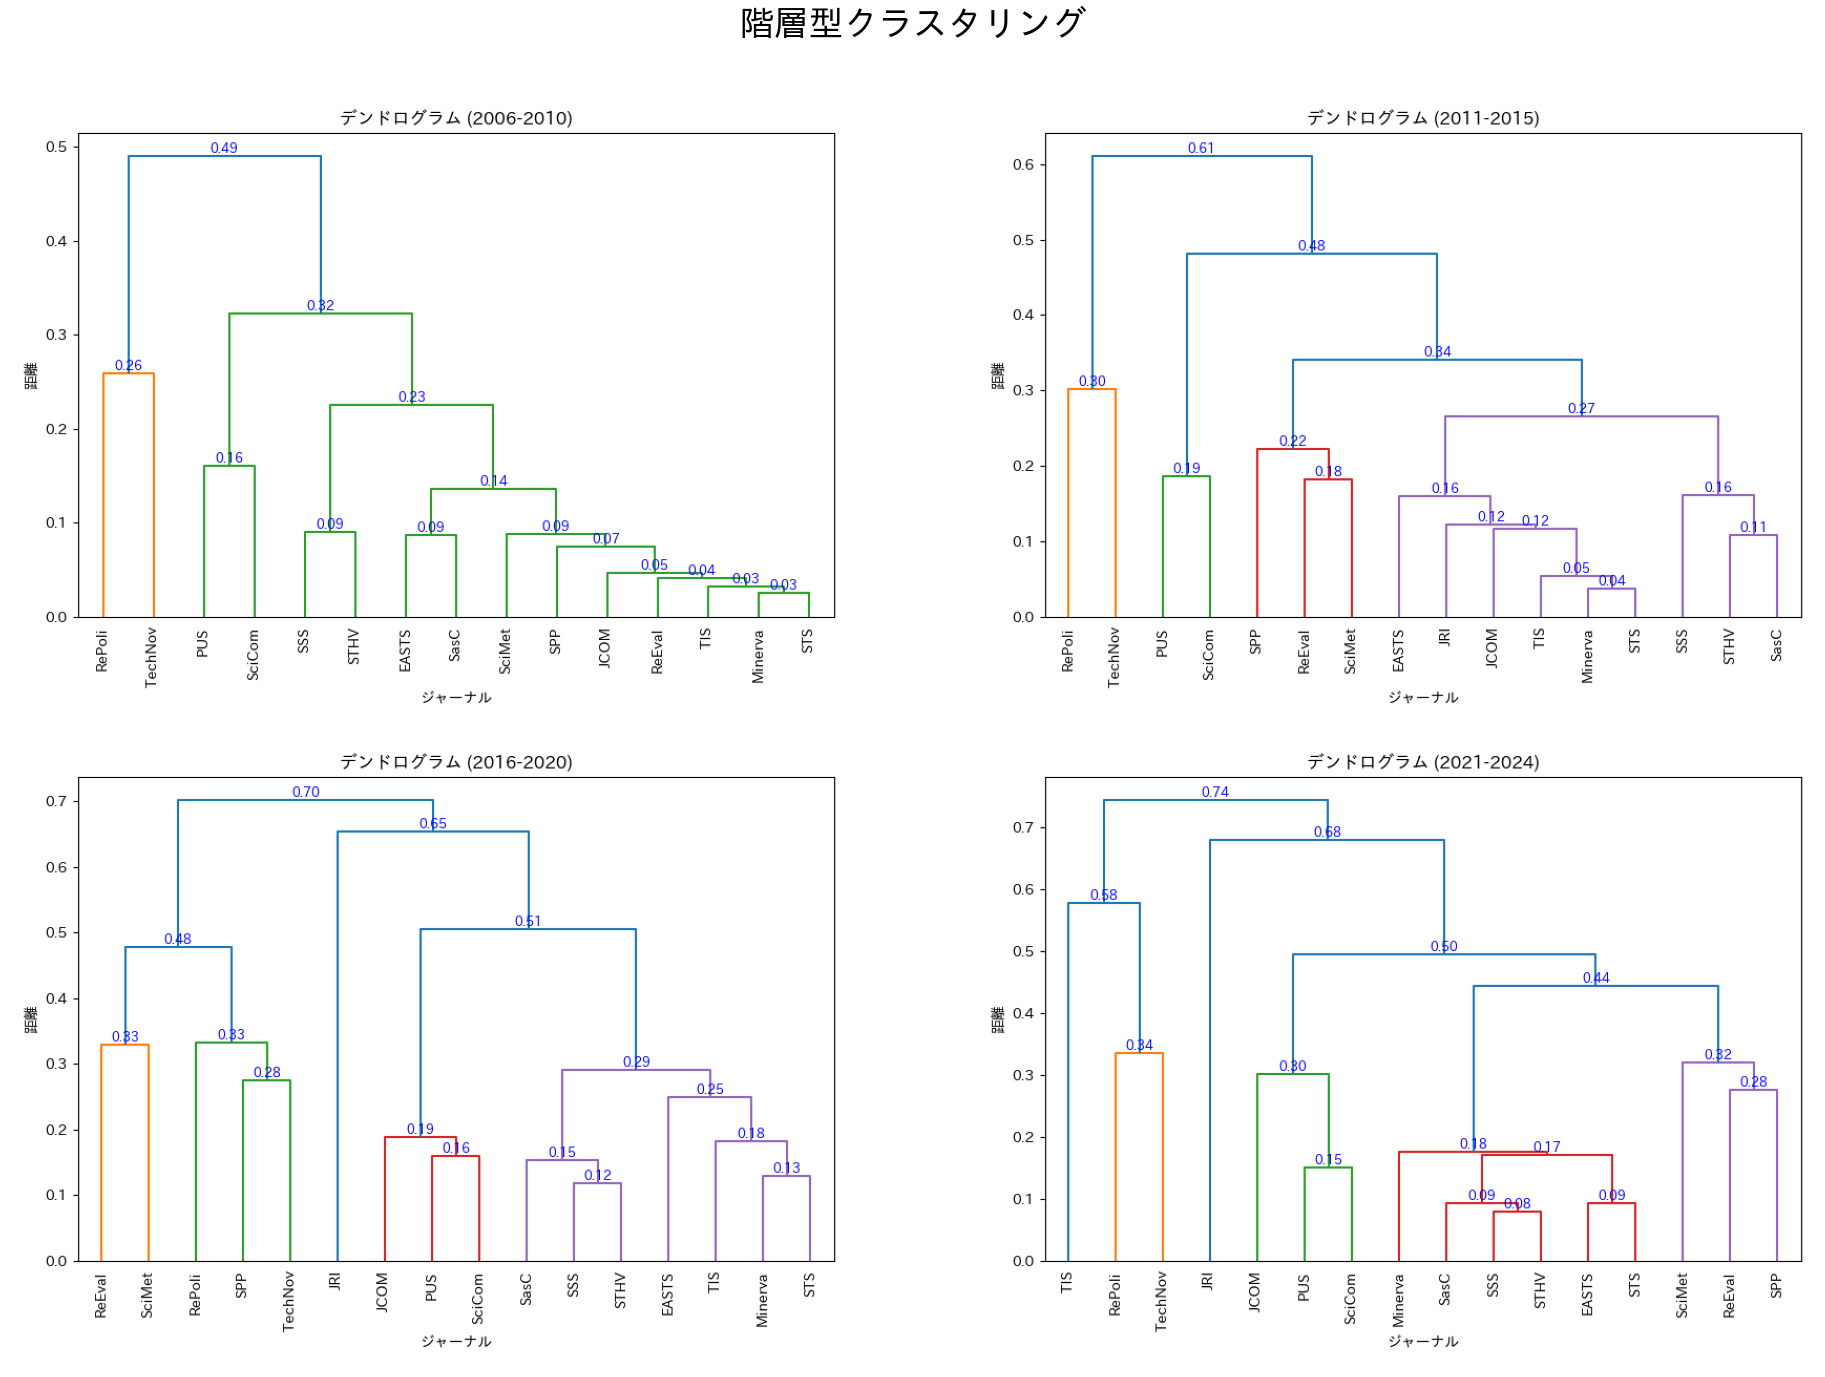

In [ ]:
# クラスタリングオブジェクトを作成
clustering = CitationNetworkClustering(all_df, linkage_method='ward')

# 時間ごとのデータ処理とデンドログラム作成
clustering.process_time_periods(normalize=True, linkage_method='ward', threshold=0.34)

# 最後の4つのプロットを2x2に配置して表示
clustering.combine_last_plots()
